# 08. PyTorch Paper Replikasi

Tujuan dari replikasi penelitian adalah untuk mengubah penelitan ML menjadi kode yang dapat digunakan


## 0. Get setup


In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu118
torchvision version: 0.21.0+cu118


In [2]:
import os
import subprocess

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except ModuleNotFoundError:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    
    # Clone the repository
    subprocess.run(["git", "clone", "https://github.com/mrdbourke/pytorch-deep-learning"])
    
    # Move the necessary directories and files
    if os.path.exists("pytorch-deep-learning/going_modular"):
        os.rename("pytorch-deep-learning/going_modular", "going_modular")
    if os.path.exists("pytorch-deep-learning/helper_functions.py"):
        os.rename("pytorch-deep-learning/helper_functions.py", "helper_functions.py")
    
    # Remove the cloned repository
    subprocess.run(["rmdir", "/s", "/q", "pytorch-deep-learning"], shell=True)

    # Try importing again
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

d:\UNSRI_DATA\MACHINE LEARNING\pytorch_course\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setup perangkat agnostik
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Ambil data

Tujuan hal yang akan kita lakukan adalah mengreplikasi ViT arsitektur untuk FooDVision Mini kita,

Untuk melakukannya kita butuh data

Seperti biasa, pizza, steak, sushi


In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Buat Dataset dan DataLoaders


In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Buat besaran gambar
IMG_SIZE = 224 # Datang dari tabel 3 dari penelitian ViT

# Buat alur transforms
manual_transforms = transforms.Compose([
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  transforms.ToTensor()
])

print(f"Transforms manual kita: {manual_transforms}")

Transforms manual kita: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Buat batch size sejumlah 32 (di penelitian itu 4096 tapi kali ini kita coba 32 total batch)
BATCH_SIZE = 32

# Buat DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

len(train_dataloader), train_dataloader, len(test_dataloader), test_dataloader, class_names

(8,
 3,
 ['pizza', 'steak', 'sushi'])

## 2.3 Visualisasikan gambar


In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[1], label_batch[1]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

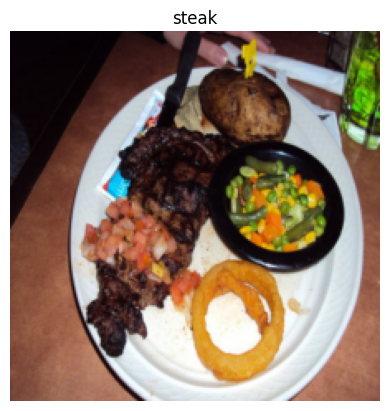

In [9]:
import matplotlib.pyplot as plt

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replikasi ViT

Untuk memnbuat itu lebih mudah dimengerti, kita dapat memecahnya menjadi beberapa bagian kecil:

- **Inputs** - Apa yang akan ke model (image tensors)
- **Outputs** - Apa yang keluar dari model/layer/block? (Kita ingin model mengeluarkan gambar klasifikasi)
- **Layers** - Mengambil input, memanipulasi dengan fungsi (ex. self-attention)
- **Block** - Koleksi dari tiap layer
- **Model** - Koleksi dari tiap block


### 3.1 Merangkai ViT: Bagian dari puzzle

- Figure 1: Rangkaian visual; dari arsitektur
- Ke-empat ekuasi: Ekuasi matematika dimana mendefinisikan fungsi dari tiap layer/block
- Table 1/3: Mencoba berbeda hyperparameter untuk arsitektur dan pelatihan
- Text


#### >>>> Rangkaian 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

- Embedding = Adalah representasi yang dapat dipelejari, dimulai dengan angka acak dan ditingkatkan dari waktu ke waktu. Sebuah konsep yang kuat dalam pembelajaran mesin
- MLP, Multi Layer Perceptron = Tumpukan lapisan di atas satu sama lain.


#### >>>> Ke-empat Ekuasi

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

#### Persamaan 1:

Gambaran umum dari model ditunjukkan pada Gambar 1.
Transformer standar menerima masukan berupa urutan 1D dari penyandian token. Untuk menangani gambar $2 \mathrm{D}$,
kita mengubah bentuk gambar $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ menjadi urutan potongan $2 \mathrm{D}$ yang dipipihkan $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, di mana $(H, W)$ adalah resolusi gambar asli, $C$ adalah jumlah saluran, $(P, P)$ adalah resolusi setiap potongan gambar, dan $N=H W / P^{2}$ adalah jumlah potongan yang dihasilkan, yang juga berfungsi sebagai panjang urutan masukan efektif untuk Transformer.

Transformer menggunakan ukuran vektor laten konstan $D$ di semua lapisannya, jadi kita memipihkan potongan dan memetakan ke dimensi $D$ dengan proyeksi linier yang dapat dilatih (Persamaan 1). Kami menyebut keluaran dari proyeksi ini sebagai penyandian potongan (patch embeddings).

Persamaan 1:

Penyandian posisi ditambahkan ke penyandian potongan untuk mempertahankan informasi posisi. Kami menggunakan penyandian posisi $1 \mathrm{D}$ yang dapat dilatih secara standar, karena kami tidak melihat peningkatan kinerja yang signifikan dengan menggunakan penyandian posisi 2D yang lebih canggih (Lampiran D.4). Urutan vektor penyandian yang dihasilkan berfungsi sebagai masukan ke encoder.

Dalam pseudocode:

```python
# Persamaan 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]

```

---

#### Persamaan 2:

Encoder Transformer (Vaswani et al., 2017) terdiri dari lapisan-lapisan bergantian antara multiheaded self-attention (MSA, lihat Lampiran A) dan blok MLP (Persamaan 2, 3). Layernorm (LN) diterapkan sebelum setiap blok, dan koneksi residual setelah setiap blok (Wang et al., 2019; Baevski & Auli, 2019).

Dalam pseudocode:

```python
# Persamaan 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Persamaan 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```

---

#### Persamaan 4:

Serupa dengan token [class] pada BERT, kami menambahkan penyandian yang dapat dilatih di awal urutan potongan yang telah disandikan ($z_{00} = x_{class}$), di mana keadaan pada keluaran encoder Transformer ($z_{0L}$) berfungsi sebagai representasi gambar $y$ (Persamaan 4). Baik selama pre-training maupun fine-tuning, kepala klasifikasi terhubung ke $z_{0L}$. Kepala klasifikasi ini diimplementasikan menggunakan MLP dengan satu lapisan tersembunyi selama pre-training dan satu lapisan linier tunggal selama fine-tuning.

MLP (Multilayer Perceptron):

Jaringan saraf dengan sejumlah lapisan tertentu.

Menggunakan satu lapisan tersembunyi selama training.

Menggunakan satu lapisan linier tunggal selama fine-tuning.

# Equation 4

```python
y = Linear_layer(LN_layer(x_output_MLP_block))

```

---


### >>>> Tabel 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)


- **ViT-Base**, **ViT-Large**, dan **ViT-Huge** adalah berbagai ukuran dari arsitektur model yang sama.
- **ViT-B/16** = ViT-Base dengan ukuran patch gambar 16x16.
- **Layers** - jumlah layer (lapisan) pada encoder Transformer.
- **Hidden size $D$** - ukuran embedding yang digunakan di seluruh arsitektur.
- **MLP size** - jumlah unit/neurons tersembunyi dalam MLP (Multilayer Perceptron).
- **Heads** - jumlah kepala pada mekanisme multi-head self-attention.


## 4. Ekuasi 1: Membagi data menjadi patches dan membuat kelas, posisi, dan embed patch

Layers = input -> function -> clear_output

Apa bentuk inputnya?

Apa bentuk outputnya?

- Input shape: (224,224,3) -> single image -> (height, width, color channel)
- Output shape: **???**

---

- Input image: $H\times{W}\times{C}$
- Output image: ${N \times\left(P^{2} \cdot C\right)}$

_Note:_

- H = tinggi
- W = lebar
- C = channel warna
- P = besar patch
- N = jumlah patches = (height \* width) / p^2
- D = Ukuran vektor laten = embedding dimension (liattable 1)


In [10]:
# Contoh nilai
height = 224
width = 224
color_channels = 3
patch_size = 16 #L16 -> (16x16) patch size

# Kalukasi jumlah patches
number_of_patches = int((height*width) / patch_size ** 2)
number_of_patches

196

In [11]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Ubah gambar menjadi patches


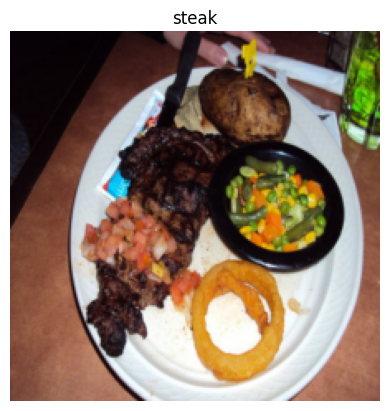

In [12]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [13]:
image.shape

torch.Size([3, 224, 224])

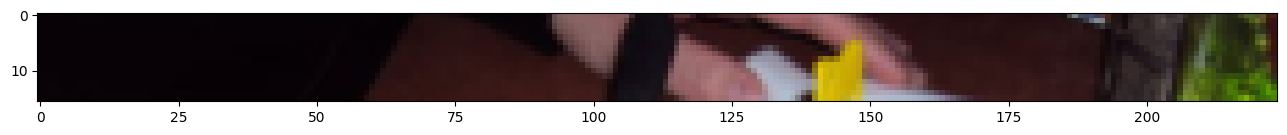

In [14]:
# Ambil baris atas dari gambar
image_permuted = image.permute(1,2,0)

# Index untuk plot top row dari pixel
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Jumlah patch per baris: 14.0 
 Ukuran patch: 16 piksel x 16 piksel  


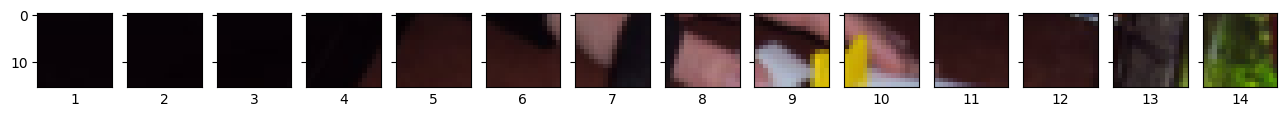

In [15]:
# Perssiapkan kode untuk meemtakan baris atas sebagai patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0
print(f"Jumlah patch per baris: {num_patches} \n Ukuran patch: {patch_size} piksel x {patch_size} piksel  ")

# Buat subplot
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size)
                        )

# Iterate through number of patchess di baris atas
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_xticks([])

Jumlah patch per baris: 14.0  
Jumlah patch per kolom: 14.0  
Total patch: 196.0  
Ukuran patch: 16 piksel x 16 piksel


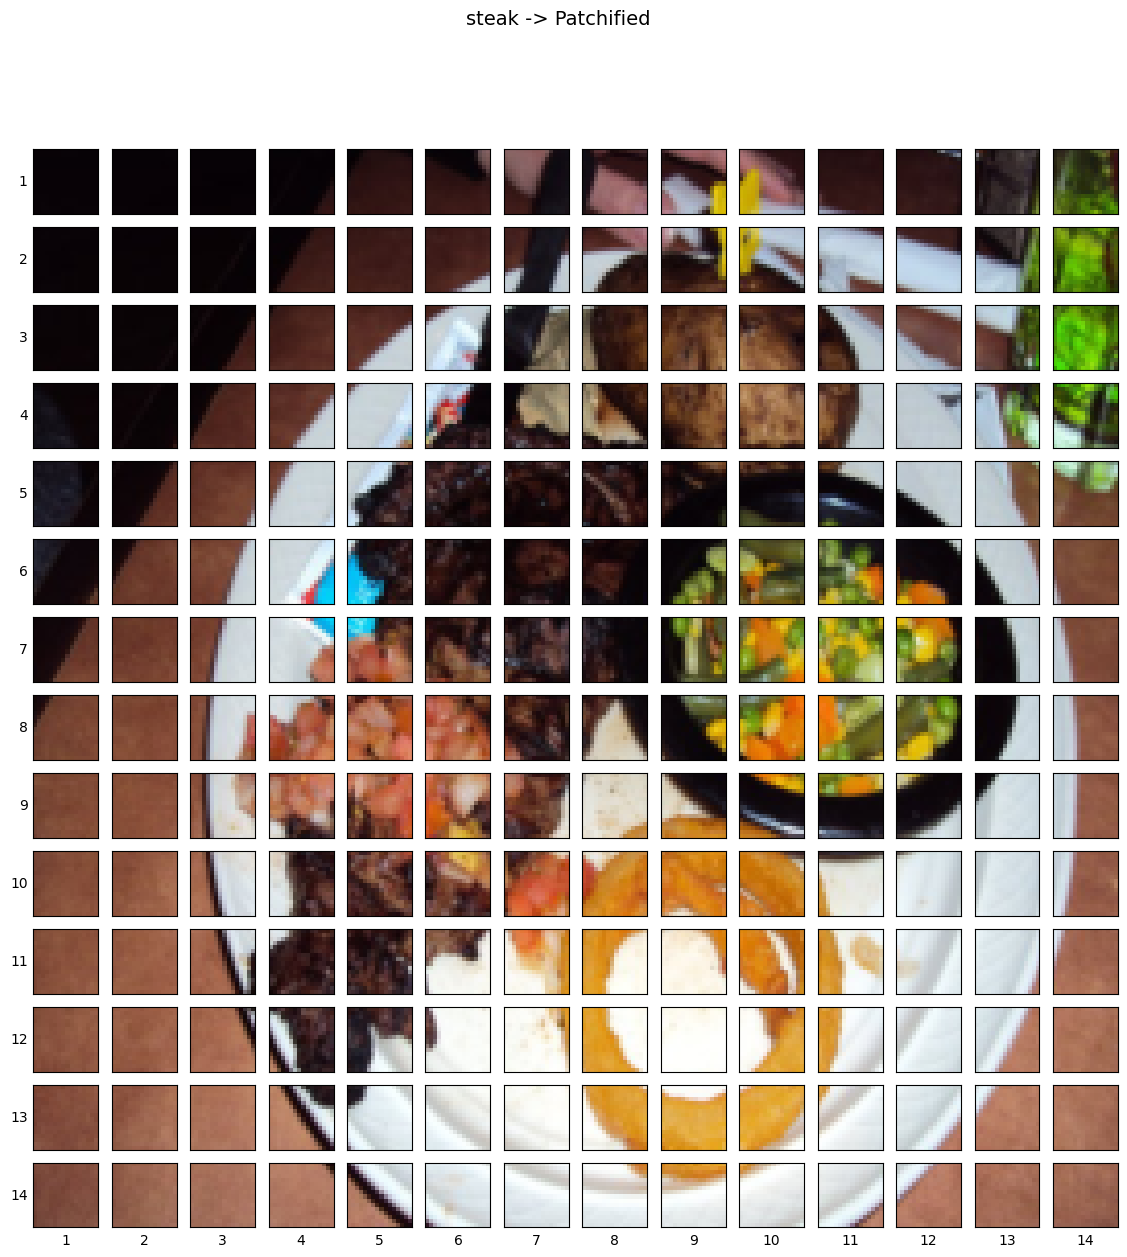

In [16]:
# Buat code untuk memetakan semua gambar sebagai patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0, "Ukuran gambar harus dapat dibagi dengan ukuran patch"
print(f"Jumlah patch per baris: {num_patches}\
  \nJumlah patch per kolom: {num_patches}\
  \nTotal patch: {num_patches*num_patches}\
  \nUkuran patch: {patch_size} piksel x {patch_size} piksel")

# Buat subplot
fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Ulangi tiap tinggi dan lebar dari gambar
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    #Petakan gambar termutasi dengan axes berbeda
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :])
    # Buat informasi label
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

# Siapkan title untuk plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()


### 4.3 Membuat patch gambar dan mengubahnya menjadi patch embedding

Mungkin kita bisa membuat patch gambar dan patch embedding dalam satu langkah menggunakan `torch.nn.Conv2d()` dengan mengatur parameter `kernel_size` dan `stride` ke `patch_size`.


In [17]:
# Membuat layer conv2d untuk mengubah gambar menjadi patch dari feature map yang dapat dipelajari (embedding)
from torch import nn

# Tetapkan besaran  patch
patch_size = 16

# Buat conv2d layer dengan hperparameter dengan ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

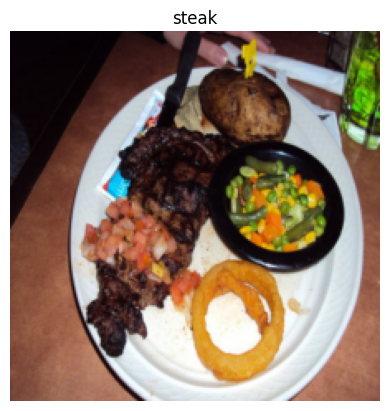

In [18]:
# Visualkan satu gambar
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [19]:
# Masukkan gambar kedalam convulitional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # tambahkan dimensi untuk batch
print(image_out_of_conv.shape) 

torch.Size([1, 768, 14, 14])


Sekarang kita telah melewatkan satu gambar ke layer `conv2d` kita, bentuknya adalah:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```


Menampilkan feature map konvolusional acak dari indeks: [73, 620, 590, 554, 227]


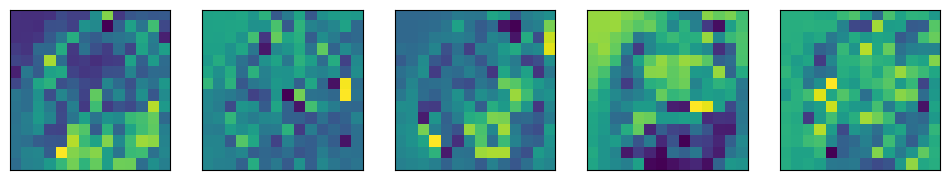

In [20]:
# Plot feature map konvolusional (embedding) secara acak
import random 
random_indexes = random.sample(range(0, 758), k=5)
print(f"Menampilkan feature map konvolusional acak dari indeks: {random_indexes}")

# Buat plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# Petakan gambar acak dari feature map
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # menghapus dimensi batch, dan menghapus dari grad tracking
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [21]:
# Ambil satu fitur map dalam bentuk tensor
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 4.1866e-03,  3.3883e-03,  3.2773e-03, -2.4490e-03,  1.3195e-02,
            3.2164e-02,  6.7869e-03, -9.4534e-02, -6.8910e-02, -1.1958e-01,
            3.6466e-02,  2.6045e-02, -1.9642e-03,  1.2218e-02],
          [ 2.1956e-03,  4.5232e-03,  2.2083e-04,  2.0479e-02,  2.9424e-02,
           -2.4535e-02,  1.1517e-01,  3.3743e-01,  1.4779e-01,  2.8329e-01,
            1.5016e-01,  7.7553e-03,  1.0328e-01, -5.5645e-02],
          [ 3.1203e-03,  4.1597e-03,  2.8481e-02,  3.8281e-02, -9.2392e-02,
            1.7083e-01,  1.3265e-02,  1.8039e-01,  5.1868e-02,  6.1535e-03,
            2.4648e-01,  1.6538e-01,  1.3646e-01, -2.6125e-02],
          [-1.8832e-02,  4.5039e-03,  3.3805e-02,  7.1609e-02,  2.1808e-01,
            2.1659e-01,  1.6319e-01, -4.4965e-02, -3.1008e-03,  1.1475e-01,
            1.3709e-01,  8.2897e-02,  1.7883e-02,  2.7000e-02],
          [ 1.3561e-02,  3.4418e-02,  4.1545e-02,  1.0667e-01,  3.2431e-01,
            4.6249e-02,  5.3684e-02,  3.4062e-03,  6.7429e-0

### 4.4 Meratakan (FLattening) patch embedding dengan `torch.nn.Flatten()`


Saat ini kita memiliki serangkaian feature map konvolusional (patch embedding) yang perlu kita flatten menjadi urutan patch embedding untuk memenuhi kriteria input dari ViT Transformer Encoder.


In [22]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Yang kita inginkan: (batch_size, number_of_patches, embedding_dim)


In [23]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


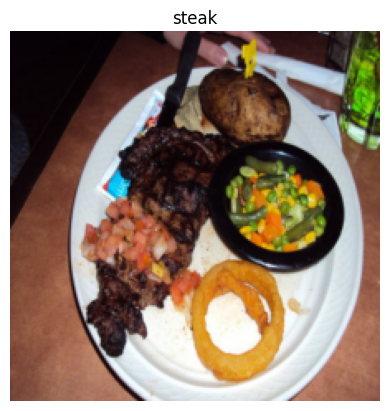

In [24]:
# Gabungkan semuanya
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Ubah gambar menjadi
image_out_of_conv = conv2d(image.unsqueeze(0)) # tambahkan dimensi batch
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [25]:
# Rangkai ulang output dari flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


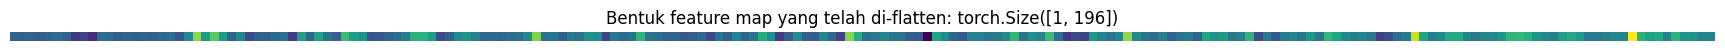

In [26]:
# Mengambil satu feature map yang telah di-flatten
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Memvisualisasikan feature map yang telah di-flatten
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Bentuk feature map yang telah di-flatten: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Mengubah layer patch embedding ViT menjadi modul PyTorch

Kita ingin modul ini melakukan beberapa hal:

1. Membuat kelas bernama `PatchEmbedding` yang mewarisi dari `nn.Module`.
2. Menginisialisasi dengan hyperparameter yang sesuai, seperti jumlah channel, dimensi embedding, dan ukuran patch.
3. Membuat layer untuk mengubah gambar menjadi patch yang di-embed menggunakan `nn.Conv2d()`.
4. Membuat layer untuk mem-flatten feature map dari output layer pada poin 3.
5. Mendefinisikan metode `forward()` yang mendefinisikan proses komputasi maju (misalnya, melewati layer dari poin 3 dan 4).
6. Memastikan bentuk output layer mencerminkan bentuk output yang dibutuhkan dari patch embedding.


In [27]:
# 1. Buat kelas bernama PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Inisialisasi layyer dengan hyperparameter yang tepat
  def __init__(self,
               in_channels: int= 3,
               patch_size: int= 16,
               embedding_dim: int= 768): # Dari table 1 ViT-Base
    super().__init__()

    self.patch_size = patch_size
    
    # 3. Buat layer untuk mengubah gambar menjadi embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    
    # 4. Buat layyer untuk melakukan flatten feature map output kita
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
    
  # 5. Definisikan forward method untuk mendifinisikan komputasi forward
  def forward(self, x):
    # Buat assertion untuk check input dalam bentuk yang benar
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input gambar harus bisa dibagi dengan patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Lakukan forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. Pastikan dimensi urutan embedding yang dikembalikan sesuai urutan (batch_size, number_of_patches, embedding_dimension)
    return x_flattened.permute(0,2,1)

In [28]:
set_seeds()

# Buat instance dari patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Melewatkan satu gambar melalui layer patch embedding
print(f"Ukuran gambar input: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # menambahkan dimensi batch ekstra
print(f"Bentuk urutan patch embedding output: {patch_embedded_image.shape}")



Ukuran gambar input: torch.Size([1, 3, 224, 224])
Bentuk urutan patch embedding output: torch.Size([1, 196, 768])


In [29]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.rand(1,3,250,250)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

### 4.6 Membuat embedding class token

Kita ingin untuk membuat class token yang dapat dipelajari dari awal patch embedding


In [30]:
patch_embedded_image

tensor([[[-0.0429, -0.0113, -0.0323,  ...,  0.0222, -0.0138,  0.0130],
         [-0.0417, -0.0110, -0.0316,  ...,  0.0199, -0.0131,  0.0109],
         [-0.0384, -0.0113, -0.0307,  ...,  0.0202, -0.0132,  0.0107],
         ...,
         [-0.5905, -0.0231, -0.0038,  ...,  0.4907, -0.4757,  0.2497],
         [-0.5391,  0.0619, -0.0972,  ...,  0.3296, -0.2619,  0.2086],
         [-0.5006,  0.0595, -0.0813,  ...,  0.3091, -0.2577,  0.2046]]],
       grad_fn=<PermuteBackward0>)

In [31]:
# Ambil batch size dan dimensi dari embedding
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [32]:
# Membuat class token embedding sebagai parameter yang dapat dipelajari dengan ukuran yang sama dengan dimensi embedding (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [33]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [34]:
# Menambahkan class token embedding di depan patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # dimensi number_of_patches

print(patch_embedded_image_with_class_embedding)
print(f"Bentuk urutan patch embedding dengan class token di depan: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0429, -0.0113, -0.0323,  ...,  0.0222, -0.0138,  0.0130],
         [-0.0417, -0.0110, -0.0316,  ...,  0.0199, -0.0131,  0.0109],
         ...,
         [-0.5905, -0.0231, -0.0038,  ...,  0.4907, -0.4757,  0.2497],
         [-0.5391,  0.0619, -0.0972,  ...,  0.3296, -0.2619,  0.2086],
         [-0.5006,  0.0595, -0.0813,  ...,  0.3091, -0.2577,  0.2046]]],
       grad_fn=<CatBackward0>)
Bentuk urutan patch embedding dengan class token di depan: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


### 4.7 Membuat embedding posisi

Kita ingin untuk membuat rangkaian satu dimensi dari posisi embedding dari tiap seri dari patch embedding


In [35]:
# Lihat urutan dari patch embedding di awal
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0429, -0.0113, -0.0323,  ...,  0.0222, -0.0138,  0.0130],
          [-0.0417, -0.0110, -0.0316,  ...,  0.0199, -0.0131,  0.0109],
          ...,
          [-0.5905, -0.0231, -0.0038,  ...,  0.4907, -0.4757,  0.2497],
          [-0.5391,  0.0619, -0.0972,  ...,  0.3296, -0.2619,  0.2086],
          [-0.5006,  0.0595, -0.0813,  ...,  0.3091, -0.2577,  0.2046]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# Kalkulasi N (nomor dari tiap patches)
number_of_patches = int((height * width) / patch_size ** 2)

# Ambil dimensi embedding
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]
embedding_dimension

# Kita bakal buat learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension))
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
# Tambahkan position embedding kedalam patch dan class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

In [38]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0429, -0.0113, -0.0323,  ...,  0.0222, -0.0138,  0.0130],
         [-0.0417, -0.0110, -0.0316,  ...,  0.0199, -0.0131,  0.0109],
         ...,
         [-0.5905, -0.0231, -0.0038,  ...,  0.4907, -0.4757,  0.2497],
         [-0.5391,  0.0619, -0.0972,  ...,  0.3296, -0.2619,  0.2086],
         [-0.5006,  0.0595, -0.0813,  ...,  0.3091, -0.2577,  0.2046]]],
       grad_fn=<CatBackward0>)

In [39]:
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9571, 0.9887, 0.9677,  ..., 1.0222, 0.9862, 1.0130],
         [0.9583, 0.9890, 0.9684,  ..., 1.0199, 0.9869, 1.0109],
         ...,
         [0.4095, 0.9769, 0.9962,  ..., 1.4907, 0.5243, 1.2497],
         [0.4609, 1.0619, 0.9028,  ..., 1.3296, 0.7381, 1.2086],
         [0.4994, 1.0595, 0.9187,  ..., 1.3091, 0.7423, 1.2046]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Menggabungkan semuanya: dari gambar ke embedding


In [40]:
# Berikan seeds
set_seeds()

# 1. Atur patch size nya
patch_size = 16

# 2. Print bentuk dari gambar aslinya, dan ambil dimensi dari gambarnya
print(f"Gambar dalam bentuk tensor: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Ambil tensor gambar dan tambahkan dimensi untuk letakin batch nya
x = image.unsqueeze(0)
print(f"Bnetuk input gambar setelah kita buat ruang untuk batch: {x.shape}")

# 4. Buat layer untuk patch embedding nya
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Masukkan input gambar kedalam PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"\nBentuk patch embedding: {patch_embedding.shape}")

# 6. Buat class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,
                                      1,
                                      embedding_dimension,
                                      requires_grad=True))
print(f"Bentuk class token embedding: {class_token.shape}")

# 7. Masukkan class token embedding kedalam dimensi pertama patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Bentuk Patch embedding dengan class token: {patch_embedding_class_token.shape}")

# 8. Buat position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             embedding_dimension),
                                             requires_grad=True)

# 9. tambakan position embedding kedalam patch embedding yang sudah disertai class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"\nPatch and position embedding shape: {patch_and_position_embedding.shape}")

Gambar dalam bentuk tensor: torch.Size([3, 224, 224])
Bnetuk input gambar setelah kita buat ruang untuk batch: torch.Size([1, 3, 224, 224])

Bentuk patch embedding: torch.Size([1, 196, 768])
Bentuk class token embedding: torch.Size([1, 1, 768])
Bentuk Patch embedding dengan class token: torch.Size([1, 197, 768])

Patch and position embedding shape: torch.Size([1, 197, 768])


## Ekuasi 2: Multihead Self-Attention (MSA Block)

- Multihead self-attention: Bgiaman mana dari semua urutan yang harus memiliki atensi lebih dengan dirinya?
  - Dalam kasus kita, kita memiliki serial dari tiap patches gambar dari embbeded. Patch mana yang sifnifikan berhubungan dengan patch lain?
  - Kita ingin neural network kita (ViT) belajar tentang relasi dan reoresentasi
- LayerNorm = Layer normalisasi adalah teknik untuk menormalisasi distribusi dari layer ditengah. Ini memungkinkan membuat gradien yang lebih halus, mempercepat training, dan generelisasi akurasi yang baik
  - Normalization = membuat semuanya memiliki rerata yang sama dan standard deviasi yang sama
  - Kapan kita melakukan normalize didalam dimensi embbeding? itu seperti membuat tanggal didalam tangga dengan ukurany yang sama?
  - Misalnya kita punya tangga, nah tangganya tingginya beda, bentuknya beda beda, lebarnya beda beda, pasti kita bakal kesulitan buat nurunin tangganya? nah karena itu kita butuh normalisasi, kita samakan tiap bentuk tangganya agar kita bisa lebih mudah.


In [48]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Membuat blok Multihead self-attention"""

  def __init__(self,
               embedding_dim: int= 768, # Bentuk hidden dari D
               num_heads: int = 12, # dari Table 1 ViT-Base
               attn_dropout: int = 0):
    super().__init__()
    
    # Buat norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Buat multihead atttention (MSA)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)
    
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key = x,
                                         value = x,
                                         need_weights = False)
    return attn_output

In [49]:
# Buat instance dari MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass patch dan posisi embedding image ke MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Bentuk input dari MSA block: {patch_and_position_embedding.shape}")
print(f"Bentuk output dari MSA block: {patched_image_through_msa_block.shape}")

Bentuk input dari MSA block: torch.Size([1, 197, 768])
Bentuk output dari MSA block: torch.Size([1, 197, 768])
